In [2]:
import wandb
import pandas as pd

In [3]:
api = wandb.Api()
project="subset-search-correlation"
entity="johnny-gary"
runs = api.runs(entity + "/" + project)

In [5]:
summary_list, tags_list, name_list = [], [], []
for run in runs:
    summary_list.append(run.summary._json_dict)
    name_list.append(run.name)
    tags_list.append(run.tags)


runs_df = pd.DataFrame({
    "SUMMARY": summary_list,
    "NAME": name_list, 
    "TAGS": tags_list
    })


In [8]:
summary_list[0]

[{'loss': 0.0006979213212616742,
  '_step': 4827,
  '_runtime': 389,
  '_timestamp': 1666326346,
  'batch_size': 8,
  'model_seed': 1,
  'sst:val_acc': 0.6639418710263397},
 {'run_time': 561.76,
  'batch_size': 8,
  'model_seed': 1,
  'sst:val_acc': 0.7983651226158038,
  '_runtime': 565,
  '_step': 5014,
  '_wandb': {'runtime': 564},
  '_timestamp': 1666325953,
  'sst2_final_test:accuracy': 0.8,
  'sst2_final_valid:accuracy': 0.7983651226158038,
  'loss': 1.2799998330592643e-05},
 {'sst2_final_test:accuracy': 0.6683257918552036,
  'sst2_final_valid:accuracy': 0.6730245231607629,
  'loss': 0.0005754395388066769,
  '_wandb': {'runtime': 405},
  '_runtime': 405,
  'run_time': 401.73,
  '_timestamp': 1666325384,
  'sst:val_acc': 0.6730245231607629,
  '_step': 5014,
  'batch_size': 8,
  'model_seed': 1},
 {'batch_size': 8,
  'sst2_final_test:accuracy': 0.8262443438914027,
  '_timestamp': 1666324975,
  '_step': 5014,
  '_wandb': {'runtime': 563},
  '_runtime': 564,
  'run_time': 560.85,
  'm

In [1]:
run

Exception: you must provide at least a filename.

In [14]:
from typing import NamedTuple
class ValidAccuracy(NamedTuple):
    step: float
    accuracy: float 

class Comparison(NamedTuple):
    run_name: str 
    first_step_accuracy: ValidAccuracy
    last_step_accuracy: ValidAccuracy
    test_acc: float


comparisons = []
for run in runs: 
    if run.state == "finished" and "roberta-base" in run.tags: 
        if len(run.history(keys=['sst:val_acc'])) >= 3 and 'sst2_final_test:accuracy' in run.summary._json_dict:
            first_step, last_step = run.history(keys=['sst:val_acc']).iloc[0], run.history(keys=['sst:val_acc']).iloc[2]
            first_step_acc = ValidAccuracy(step=first_step._step, accuracy=first_step["sst:val_acc"])
            last_step_acc = ValidAccuracy(step=last_step._step, accuracy=last_step["sst:val_acc"])        
            comparisons.append(Comparison(run_name=run.name, first_step_accuracy=first_step_acc, last_step_accuracy=last_step_acc, test_acc=run.summary._json_dict['sst2_final_test:accuracy']))

Linear correlation pearson=(0.8711447046072557, 1.4823779208692794e-14)
Rank correlation spearman=SpearmanrResult(correlation=0.8180471812977559, pvalue=1.2051457943760756e-11)


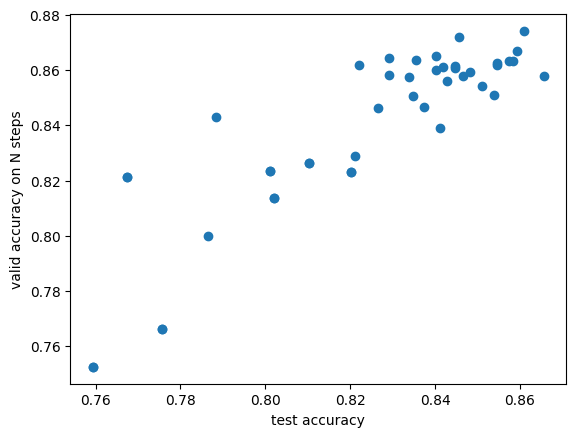

In [21]:
import scipy.stats
import matplotlib.pyplot as plt
first_step_valid_acc = [comparison.first_step_accuracy.accuracy for comparison in comparisons]
last_step_valid_acc = [comparison.last_step_accuracy.accuracy for comparison in comparisons]
roberta_test_accs = [comparison.test_acc for comparison in comparisons]
x = first_step_valid_acc 
# x = last_step_valid_acc
y = roberta_test_accs
assert len(x) == len(y) 
pearson = scipy.stats.pearsonr(x, y)
spearman = scipy.stats.spearmanr(x, y)
print(f"Linear correlation {pearson=}")
print(f"Rank correlation {spearman=}")
plt.scatter(x, y)
plt.ylabel('valid accuracy on N steps')
plt.xlabel('test accuracy')
plt.show()

In [15]:
comparisons

[Comparison(run_name='flowing-monkey-89', first_step_accuracy=ValidAccuracy(step=502.0, accuracy=0.7865576748410535), last_step_accuracy=ValidAccuracy(step=1504.0, accuracy=0.779291553133515), test_acc=0.8),
 Comparison(run_name='vocal-universe-87', first_step_accuracy=ValidAccuracy(step=502.0, accuracy=0.810172570390554), last_step_accuracy=ValidAccuracy(step=1504.0, accuracy=0.8056312443233424), test_acc=0.8262443438914027),
 Comparison(run_name='logical-sun-85', first_step_accuracy=ValidAccuracy(step=502.0, accuracy=0.8010899182561307), last_step_accuracy=ValidAccuracy(step=1504.0, accuracy=0.7956403269754768), test_acc=0.8235294117647058),
 Comparison(run_name='flowing-disco-83', first_step_accuracy=ValidAccuracy(step=502.0, accuracy=0.8019981834695731), last_step_accuracy=ValidAccuracy(step=1504.0, accuracy=0.7992733878292462), test_acc=0.8135746606334842),
 Comparison(run_name='zany-serenity-81', first_step_accuracy=ValidAccuracy(step=502.0, accuracy=0.7674841053587648), last_ste

In [16]:
run_steps = [runs_df.iloc[i].SUMMARY['_step'] for i in range(len(runs_df))]

In [18]:
len(run_steps), len([step for step in run_steps if step < 3000])

(42, 32)

In [19]:
[step for step in run_steps if step < 3000] # most runs were early stopped

[2008,
 2509,
 2509,
 2509,
 1507,
 2008,
 2509,
 2509,
 2509,
 2509,
 2509,
 2008,
 2008,
 2008,
 1507,
 1507,
 2008,
 1507,
 2008,
 2509,
 2509,
 2509,
 2008,
 2509,
 2509,
 2509,
 1507,
 2509,
 1507,
 1507,
 1507,
 2509]

In [20]:
from typing import Tuple, List

def get_test_accs_for_all_seeds(train_size: int, seeds: List[int]) -> Tuple[List[int], List[int]]:
    roberta_test_accs = {}
    electra_test_accs = {}
    for row in runs_df.iterrows():
        tags = set(row[1].TAGS)
        test_acc = row[1].SUMMARY['sst2_final_test:accuracy']
        seed = int(row[1].TAGS[0])
        if f"fixed-roberta" in tags and "correlation" in tags:
            if "roberta-base" in tags: 
                roberta_test_accs[seed] = test_acc
            elif "google/electra-small-discriminator" in tags: 
                electra_test_accs[seed] = test_acc
    roberta_test_accs_list = [roberta_test_accs[i] for i in seeds]
    electra_test_accs_list = [electra_test_accs[i] for i in seeds]
    return roberta_test_accs_list, electra_test_accs_list

spearman: SpearmanrResult(correlation=-0.17213381875702438, pvalue=0.45560041276966)


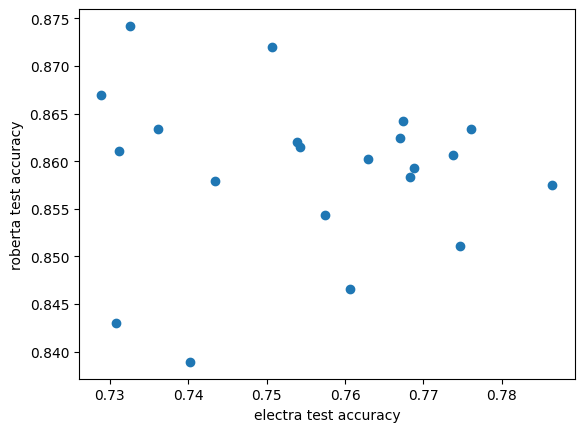

In [23]:
import scipy.stats
import matplotlib.pyplot as plt
for TRAIN_SIZE in (500,):
    roberta_test_accs_list, electra_test_accs_list = get_test_accs_for_all_seeds(train_size=TRAIN_SIZE, seeds=SEEDS) 
    x = electra_test_accs_list
    y = roberta_test_accs_list
    assert len(x) == len(y) 
    spearman = scipy.stats.spearmanr(x, y)
    print(f"spearman: {spearman}")
    plt.scatter(x, y)
    plt.ylabel('roberta test accuracy')
    plt.xlabel('electra test accuracy')
    plt.show()